In [1]:
import numpy as np
import os, random, shutil
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as img
seed_value=12345
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)
tf.keras.utils.set_random_seed(seed_value)

2023-03-28 21:52:11.743120: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 21:52:11.883772: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-28 21:52:11.883804: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-28 21:52:12.445366: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [3]:
label = ["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag"]
root_path = "rice-image-dataset"
source_path = "Rice_Image_Dataset"

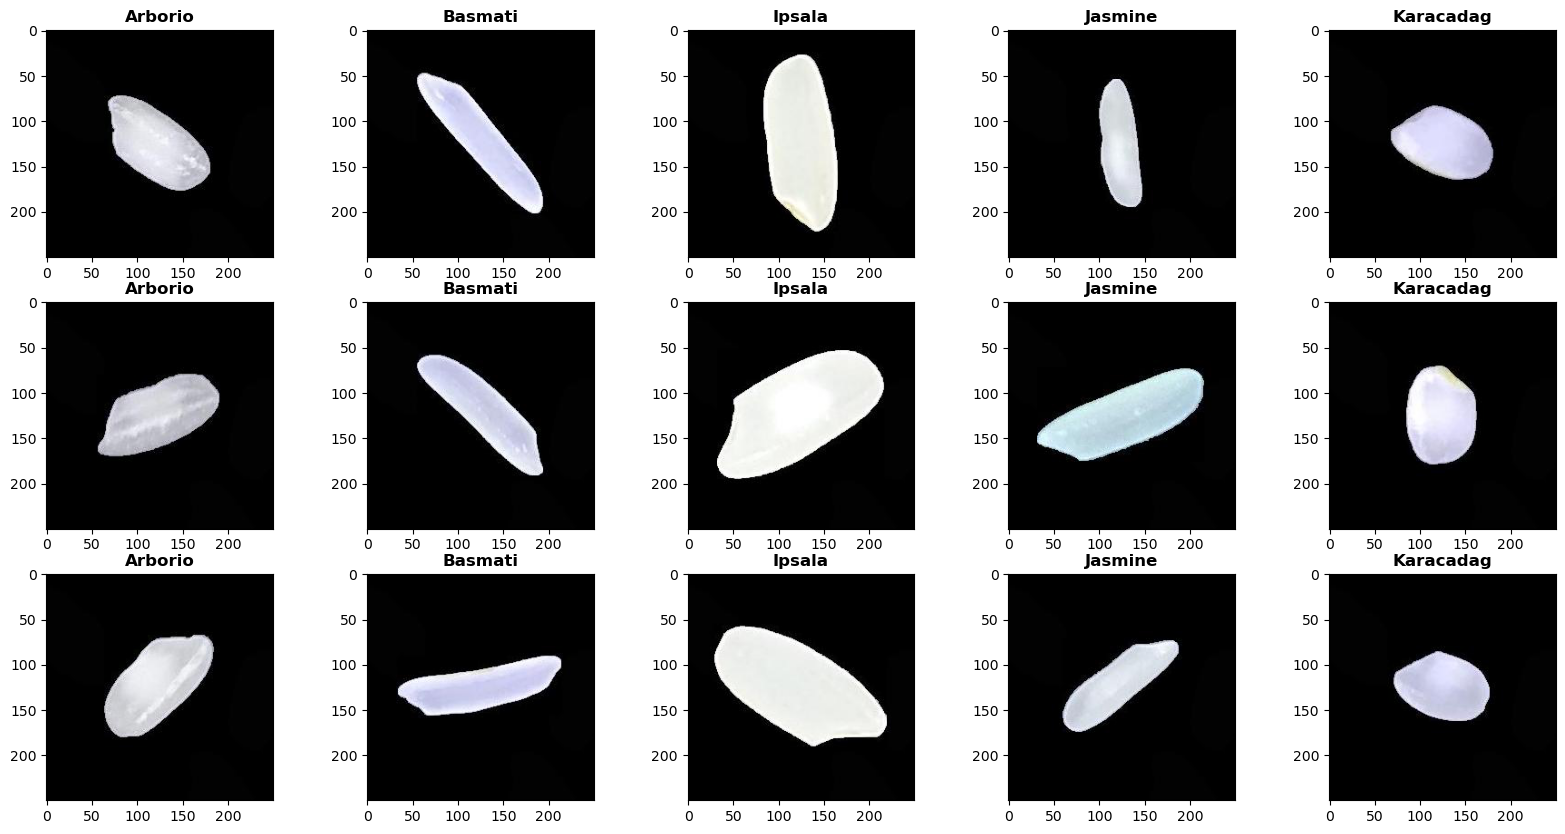

In [8]:
fig = plt.figure(figsize = (20, 10))
image_position = 0

for j in range(3):
    for index, folder in enumerate(label):
        image_position += 1
        folder_path = os.path.join(source_path, folder)
        
        fig.add_subplot(3, 5, image_position)
        plt.title(folder, fontweight='bold')
        plt.imshow(img.imread(os.path.join(folder_path, random.choice(os.listdir(folder_path)))))

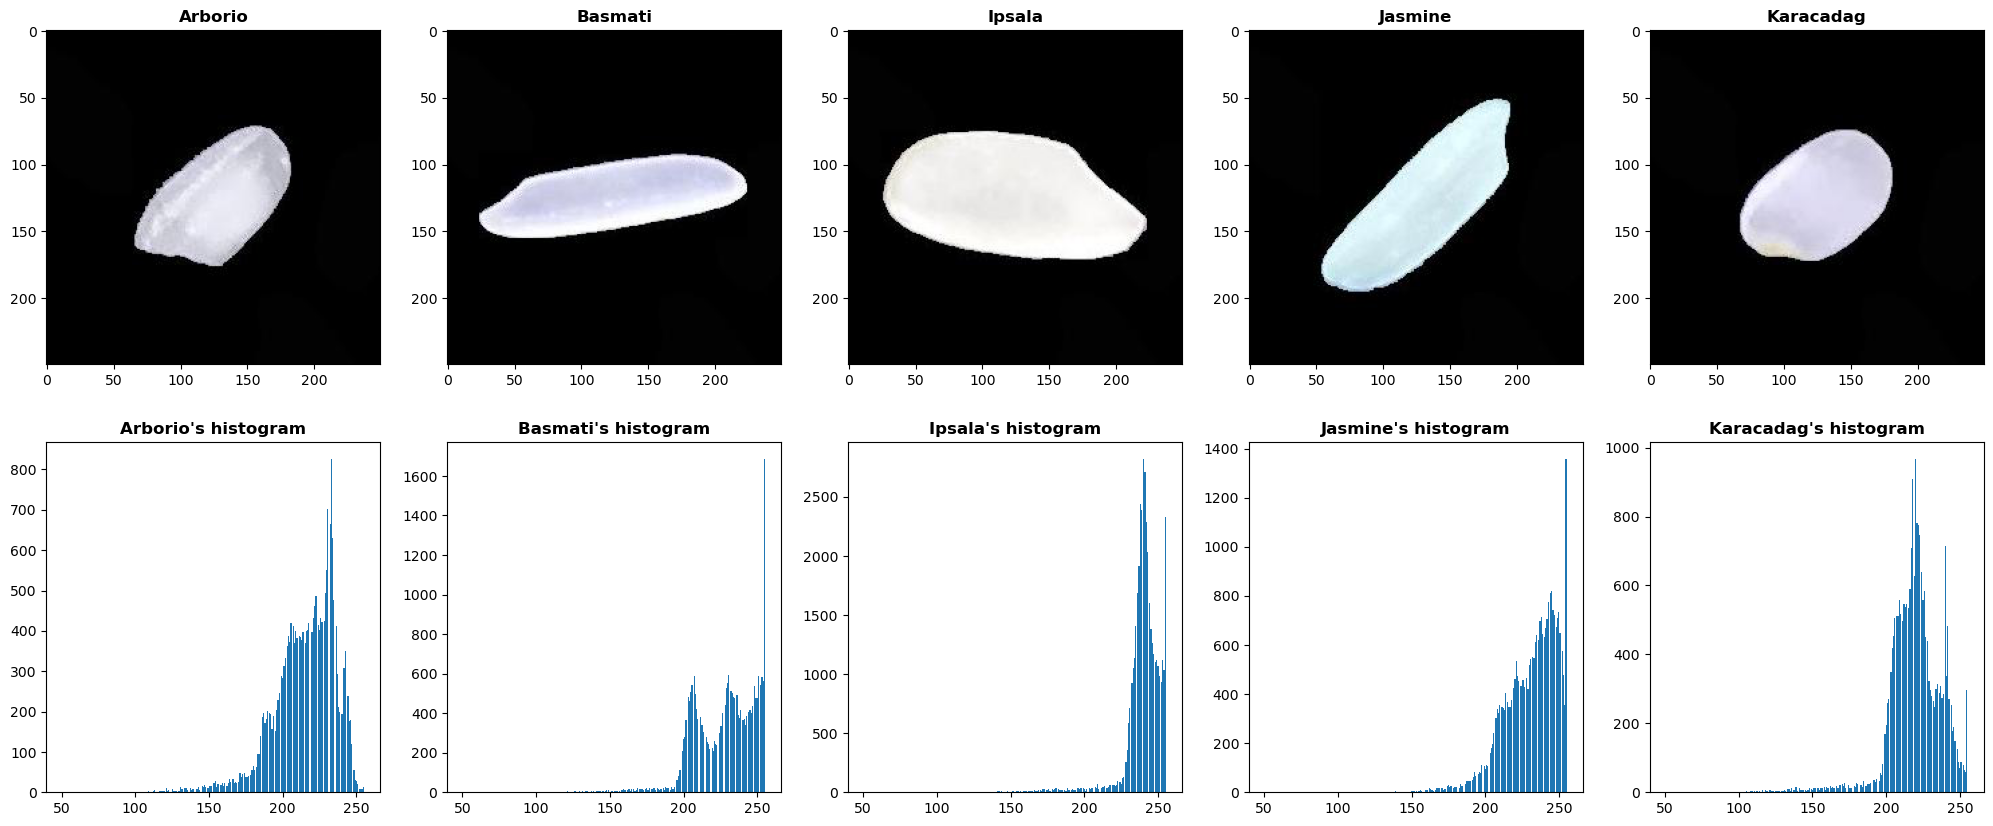

In [9]:
fig = plt.figure(figsize = (25, 10))
image_position = 0

for index, folder in enumerate(label):
    image_position += 1
    folder_path = os.path.join(source_path, folder)

    fig.add_subplot(2, 5, image_position)
    plt.title(folder, fontweight='bold')
    
    image = img.imread(os.path.join(folder_path, random.choice(os.listdir(folder_path))))
    
    # Plot image
    plt.imshow(image)
    
    # Plot its histogram
    fig.add_subplot(2, 5, image_position+5)
    plt.title(f"{folder}'s histogram", fontweight='bold')
    plt.hist(image.ravel(), bins=256, range=[50, 256])

In [10]:
target_path = 'splitted'

os.makedirs(os.path.join(target_path, 'train'))
os.makedirs(os.path.join(target_path, 'test'))

for l in label:
    os.makedirs(os.path.join(target_path, f'train/{l}'))
    os.makedirs(os.path.join(target_path, f'test/{l}'))

In [11]:
from collections import Counter

for l in label:
    full_dataset_from_this_class = os.listdir(os.path.join(source_path, l))
    to_be_train_set = random.sample(full_dataset_from_this_class, 10500)
    to_be_test_set = list((Counter(full_dataset_from_this_class) - Counter(to_be_train_set)).elements())
    
    # Copy ke folder sebelah
    for file_name in to_be_train_set:
        shutil.copyfile(
            os.path.join(source_path, l, file_name),
            os.path.join(target_path, f'train/{l}', file_name)
        )
        
    for file_name in to_be_test_set:
        shutil.copyfile(
            os.path.join(source_path, l, file_name),
            os.path.join(target_path, f'test/{l}', file_name)
        )

In [12]:
train_path = os.path.join(target_path, 'train')
test_path = os.path.join(target_path, 'test')

In [13]:
image_data_generator = ImageDataGenerator(
    rescale=1./255
)

In [14]:
train_generator = image_data_generator.flow_from_directory(
    train_path,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=64,
    shuffle=True,
    class_mode='categorical'
)

test_generator = image_data_generator.flow_from_directory(
    test_path,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=64,
    shuffle=True,
    class_mode='categorical'
)

Found 52500 images belonging to 5 classes.
Found 22500 images belonging to 5 classes.


In [15]:
from tensorflow.keras.applications import ResNet50
import keras

In [16]:
# Load pre-trained model
base_model = ResNet50(
    weights="imagenet",
    input_shape=(224, 224, 3),
    include_top=False,
)

# Freeze the base_model
base_model.trainable = False

2023-03-28 21:59:13.020600: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-28 21:59:13.020663: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-28 21:59:13.020689: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (zesus): /proc/driver/nvidia/version does not exist
2023-03-28 21:59:13.021336: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


94765736/94765736 [==============================] - 3s 0us/step


In [17]:
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(32, activation='relu')(x)
outputs = keras.layers.Dense(5, activation='softmax')(x)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 32)                3211296   
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 26,799,173
Trainable params: 3,211,461
Non-trainable params: 23,587,712
_________________________________________________________________


In [18]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.categorical_crossentropy,
    metrics=['accuracy']
)

In [19]:
result = model.fit(train_generator, epochs=10)

Epoch 1/10
821/821 [==============================] - 1871s 2s/step - loss: 0.3066 - accuracy: 0.8972
Epoch 2/10
821/821 [==============================] - 1477s 2s/step - loss: 0.0990 - accuracy: 0.9660
Epoch 3/10
821/821 [==============================] - 1297s 2s/step - loss: 0.0897 - accuracy: 0.9694
Epoch 4/10
821/821 [==============================] - 1455s 2s/step - loss: 0.0835 - accuracy: 0.9710
Epoch 5/10
821/821 [==============================] - 1349s 2s/step - loss: 0.0772 - accuracy: 0.9733
Epoch 6/10
821/821 [==============================] - 1450s 2s/step - loss: 0.0697 - accuracy: 0.9757
Epoch 7/10
821/821 [==============================] - 1430s 2s/step - loss: 0.0678 - accuracy: 0.9766
Epoch 8/10
821/821 [==============================] - 1427s 2s/step - loss: 0.0727 - accuracy: 0.9742
Epoch 9/10
821/821 [==============================] - 1282s 2s/step - loss: 0.0603 - accuracy: 0.9792
Epoch 10/10
821/821 [==============================] - 1282s 2s/step - loss: 0.068

In [20]:
model.evaluate(test_generator)

352/352 [==============================] - 549s 2s/step - loss: 0.0759 - accuracy: 0.9763


[0.07586637139320374, 0.9762666821479797]

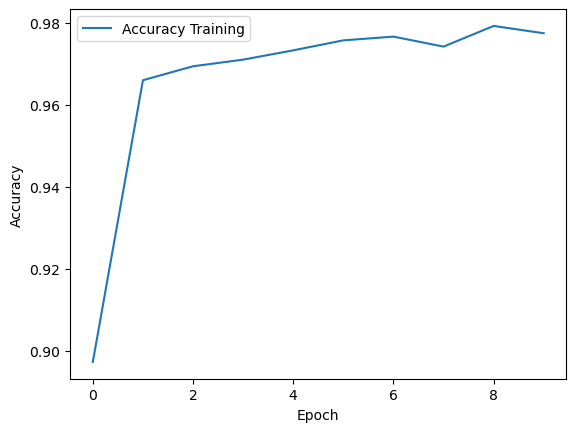

In [21]:
plt.plot(result.history['accuracy'], label='Accuracy Training')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

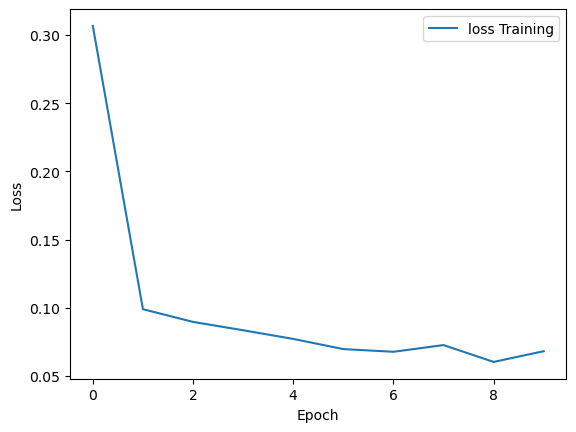

In [22]:
plt.plot(result.history['loss'], label='loss Training')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

1/1 [==============================] - 0s 41ms/step


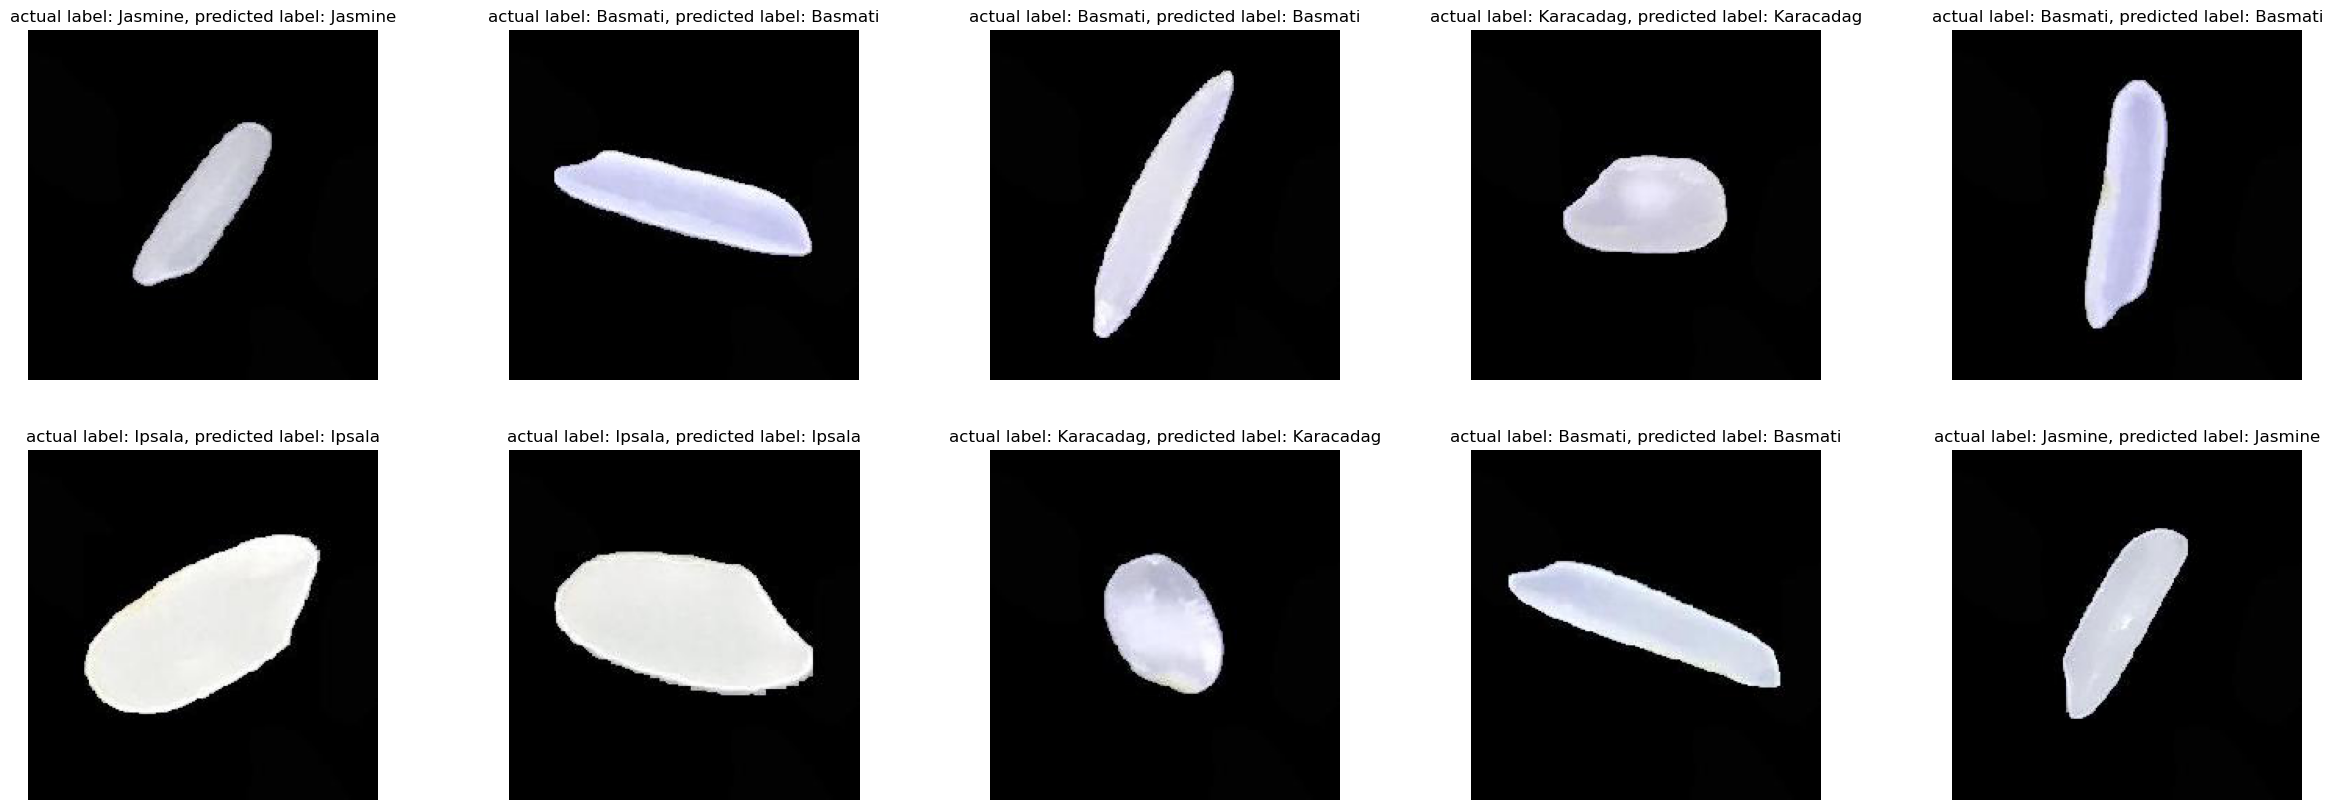

In [23]:
import tensorflow as tf
img, l = next(iter(test_generator))

plt.figure(figsize=(30,10))
for i in range(10):
    actual_label = list(label)[np.argmax(l[i])]
    predicted_label = np.argmax(model.predict(img[i][None,...]))
    plt.subplot(2,5,i+1)
    plt.axis('off')
    plt.imshow(tf.squeeze(img[i]))
    plt.title(f'actual label: {actual_label}, predicted label: {list(label)[predicted_label]}')